**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -p 8786:8786 -p 8787:8787 -d palmoreck/jupyterlab_numerical:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_numerical
```


Documentación de la imagen de docker `palmoreck/jupyterlab_numerical:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/numerical).

---

Esta nota utiliza métodos vistos en [1.5.Integracion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.5.Integracion_numerica.ipynb)

# El módulo de `multiprocessing`

Documentación en: [multiprocessing](https://docs.python.org/3.1/library/multiprocessing.html).

La implementación más utilizada de Python, [CPython](https://en.wikipedia.org/wiki/CPython) no utiliza múltiples cores por default. De tarea queda leer la discusión de la liga anterior en el apartado *Design* sobre el [Global INterpreter Lock: GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock) y el por qué CPython no soporta ejecución *multithreaded* o *multiprocesses*.

El módulo `multiprocessing` nos permite realizar procesamientos basados en procesos o threads para compartir trabajo y datos. Se recomienda usar este módulo para el *shared memory programming* (ver [2.2.Sistemas_de_memoria_compartida](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Sistemas_de_memoria_compartida.ipynb)) y para trabajos que son demandantes de CPU. Para paralelizar trabajos demandantes en I/O no se recomienda su uso.

**Otro módulo en Python para procesamiento utilizando los cores de tu máquina es [concurrent.features](https://docs.python.org/3/library/concurrent.futures.html) que provee el comportamiento principal de `multiprocessing`**. Ver [liga](https://stackoverflow.com/questions/38311431/concurrent-futures-processpoolexecutor-vs-multiprocessing-pool-pool?noredirect=1&lq=1) y [liga](https://stackoverflow.com/questions/20776189/concurrent-futures-vs-multiprocessing-in-python-3) para más sobre `concurrent.futures` y `concurrent.futures` vs `multiprocessing`.

## Nota sobre el GIL y `multiprocessing`

Aunque en Python los threads son nativos del sistema operativo (esto es, no se simulan, son realmente threads del sistema operativo creados en el hardware), están limitados por el *global interpreter lock, GIL*, de modo que un sólo thread interactúe con un objeto Python en un único tiempo.

Al usar el módulo `multiprocessing` ejecutamos en paralelo un número de **interpretadores Python** (CPython), cada uno con su propio espacio de memoria privada y su propio GIL que se ejecutan en un instante (y con un thread). 

**Comentario:** en `multiprocessing` se utilizan subprocesos en lugar de threads.

# Ejemplos

## Hello world!

En `multiprocessing` los procesos son generados al utilizar la clase `Process` para crear objetos y llamar al método `start()`. Ver [Process](https://docs.python.org/3.1/library/multiprocessing.html#multiprocessing.Process) para documentación de ésta clase.

In [1]:
from multiprocessing import Process #importamos clase Process

In [2]:
def f():
    print('hello world! de subproceso')
    
if __name__=='__main__':
    p1 = Process(target=f)
    p2 = Process(target=f)
    p1.start() #start sólo puede ser llamada una vez por objeto Process
    p2.start() 
    p1.join() #el proceso principal espera a que termine p1
    p2.join() #el proceso principal espera a que termine p2
    print('hello world! de proceso')

hello world! de subproceso
hello world! de subproceso
hello world! de proceso


**Comentario:** es una buena práctica explícitamente hacer `join`'s para cada objeto process que realizó `start`. Ver [Programming guidelines](https://docs.python.org/3.1/library/multiprocessing.html#programming-guidelines) para buenas prácticas.

La clase `Process` recibe la función a ejecutar para cada proceso con el argumento `target` y también tiene `args` para los argumentos de la función:

In [3]:
def f(s):
    print(s)
    
if __name__=='__main__':
    p1 = Process(target=f, args=('hola',))
    p2 = Process(target=f, args=('mundo',)) 
    p1.start()
    p2.start()
    p1.join()
    p2.join()

hola
mundo


**Comentarios:** 

* Obsérvese que se usa `if __name__=='__main__':` que ayuda a que los subprocesos importen el módulo `__main__` (por lo que no se ejecuta la sección que está dentro de `if __name__=='__main__':` pues no son programas principales) y continúa la ejecución de las líneas de `start` (cada subproceso ejecuta `f`) y `join`. Si se quita este statement por ejemplo:

```
def f(s):
    print(s)
p1 = Process(target=f, args=('hola',))
p2 = Process(target=f, args=('mundo',)) 
p1.start()
p2.start()
p1.join()
p2.join()
```

el notebook quedará bloqueado pues una celda con el código anterior creará subprocesos que a su vez crearán otros subprocesos, que a su vez crearán otros subprocesos... y así de forma recursiva.

* Los argumentos tienen que ser objetos *pickable* o serializados. Ver [what can be pickled and unpickled](https://docs.python.org/3/library/pickle.html#what-can-be-pickled-and-unpickled) para una lista de objetos *pickable*


* En *multiprocessing* tenemos la función `cpu_count` para determinar el número de cores que el sistema operativo puede usar. Este número es la cantidad física o simulada (hyperthreading) de cores.

In [4]:
import multiprocessing

In [5]:
multiprocessing.cpu_count()

2

## Pool of workers, ver [Using a pool of workers](https://docs.python.org/3/library/multiprocessing.html#using-a-pool-of-workers)

La clase `Pool` crea un conjunto (*pool*) de procesos tipo *worker* que procesarán las tareas a realizar vía funciones tipo `map` o `apply`. Se hace `map` del *input* hacia los procesadores y se colecta el *output* de éstos. Mientras el `map` se realiza, el proceso que lanzó el map se bloquea hasta que finalicen las tareas (aunque hay [map_async](https://docs.python.org/3.1/library/multiprocessing.html#multiprocessing.pool.multiprocessing.Pool.map_async)). El *output* es una lista.

**Obs:** el procesamiento de las tareas podríamos hacerlo con la clase `Process` de arriba pero tendríamos que utilizar un ciclo y colectar los resultados.

**Comentario:** para un gran número de tareas a realizar utilicen `Pool`, para pocas tareas a realizar (pocas=menos de $10$) utilicen `Process`.

In [6]:
from multiprocessing import Pool #importamos clase Pool

### 1) Hello world!

In [7]:
def f(dummy):
    return 'hello world!'
    
if __name__ == '__main__':
    pool = Pool(multiprocessing.cpu_count())
    results = pool.map(f,range(multiprocessing.cpu_count()))
    print(results)
    pool.close()    
    pool.join()

['hello world!', 'hello world!']


In [8]:
def f(dummy):
    return 'hello world!'
    
if __name__ == '__main__':
    num_processes=2
    pool = Pool(num_processes)
    results = pool.map(f,range(num_processes))
    print(results)
    pool.close()    
    pool.join()

['hello world!', 'hello world!']


**Con apply:**

In [9]:
def f():
    return 'hello world!'
    
if __name__ == '__main__':
    num_processes=2
    pool = Pool(num_processes)
    results = [pool.apply(f) for x in range(num_processes)]
    print(results)
    pool.close()    
    pool.join()

['hello world!', 'hello world!']


**Podemos usar un [context manager](https://book.pythontips.com/en/latest/context_managers.html#context-managers) para evitar tener líneas `pool.close()`, `pool.join()`**

In [10]:
def f(dummy):
    return 'hello world!'
    
if __name__ == '__main__':
    num_processes=2
    with Pool(processes=num_processes) as pool:
        results = pool.map(f,range(num_processes))
        print(results)

['hello world!', 'hello world!']


### 2) Pasar múltiples argumentos vía [starmap](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.starmap)

In [11]:
def f(s):
    return s
    
if __name__ == '__main__':
    num_processes=2
    with Pool(processes=num_processes) as pool:
        results = pool.starmap(f,[('hola',),('mundo',)])
        print(results)

['hola', 'mundo']


### 3) Regla compuesta del rectángulo

In [12]:
import math
import time
from scipy.integrate import quad

In [13]:
f=lambda x: math.exp(-x**2)
a=0
b=1
n=10**6
h_hat=(b-a)/n

**Forma secuencial**

In [14]:
def Rcf(f, a, b, n): #Rcf: rectángulo compuesto para f
    """
    Compute numerical approximation using rectangle or mid-point method in 
    an interval.
    Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n-1 and h_hat=(b-a)/n
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals
    Returns:
        Rcf (float) 
    """
    h_hat=(b-a)/n
    suma_res=0
    for i in range(0,n):
        x=a+(i+1/2.0)*h_hat
        suma_res+=f(x)
    return h_hat*suma_res

In [15]:
start_time = time.time()
aprox=Rcf(f,a,b,n)
end_time = time.time()

In [16]:
secs = end_time-start_time
print("Rcf tomó",secs,"segundos" )

Rcf tomó 0.3652639389038086 segundos


In [17]:
obj, err = quad(f, a, b)

In [18]:
def err_relativo(aprox, obj):
    return math.fabs(aprox-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [19]:
err_relativo(aprox,obj)

6.71939731300312e-14

La flag `-o` nos permite guardar el *output* de `timeit`.

In [20]:
Rcf_secuencial_timeit = %timeit -n 5 -r 10 -o Rcf(f,a,b,n)

315 ms ± 23.9 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


**Forma en paralelo**

In [21]:
p=multiprocessing.cpu_count() #número de procesos
ns_p=int(n/p) #número de subintervalos por proceso
              #se asume que n es divisible por p
              #si no se cumple esto, se puede definir 
              #ns_p=int(n/p)
              #y para n: 
              #n=p*ns_p

In [22]:
print("número de subintervalos:",n)

número de subintervalos: 1000000


In [23]:
print("número de subintervalos por proceso:",ns_p)

número de subintervalos por proceso: 500000


In [24]:
def Rcf_parallel(mi_id):
    begin=mi_id*ns_p
    end=begin+ns_p
    h_hat=(b-a)/n
    suma_res=0
    for i in range(begin,end):
        x=a+(i+1/2.0)*h_hat
        suma_res+=f(x)
    return suma_res
if __name__ == '__main__':
    start_time=time.time()
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel,range(p))
        aprox=h_hat*sum(results)
    end_time=time.time()

In [25]:
secs = end_time-start_time
print("Rcf_parallel tomó",secs,"segundos" )

Rcf_parallel tomó 0.34125852584838867 segundos


In [26]:
err_relativo(aprox,obj)

5.842307840730588e-14

In [27]:
%%timeit -n 5 -r 10 -o
if __name__ == '__main__':
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel,range(p))
        aprox=h_hat*sum(results)

245 ms ± 38.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 245 ms ± 38.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [28]:
Rcf_parallel_timeit=_

In [29]:
Rcf_parallel_timeit.average

0.2453967577000003

## 4) Ejemplo para pasar múltiples parámetros a una función vía un [generator](https://wiki.python.org/moin/Generators).

Las funciones definidas con `lambda` no son `pickeable`. Utilizamos la forma `def f(x):` siguiente para definir a la función.

In [30]:
def f(x):
    return math.exp(-x**2)

In [31]:
def Rcf_parallel2(t):
    f,a,b,mi_id,n,ns_p = t
    begin=mi_id*ns_p
    end=begin+ns_p
    h_hat=(b-a)/n
    suma_res=0
    for i in range(begin,end):
        x=a+(i+1/2.0)*h_hat
        suma_res+=f(x)
    return suma_res
if __name__ == '__main__':
    start_time=time.time()
    it=((f,a,b,k,n,ns_p) for k in range(p))
    h_hat=(b-a)/n
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel2,it)
        aprox=h_hat*sum(results)
    end_time=time.time()

In [32]:
secs = end_time-start_time
print("Rcf_parallel2 tomó",secs,"segundos" )

Rcf_parallel2 tomó 0.22277450561523438 segundos


In [33]:
err_relativo(aprox,obj)

5.842307840730588e-14

In [34]:
%%timeit -n 5 -r 10 -o
if __name__ == '__main__':
    it=((f,a,b,k,n,ns_p) for k in range(p))
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel2,it)
        aprox=h_hat*sum(results)


225 ms ± 14.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 225 ms ± 14.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [35]:
Rcf_parallel2_timeit=_

In [36]:
Rcf_parallel2_timeit.average

0.22461217020012553

In [37]:
def Rcf_parallel3(t):
    f,a,b,mi_id,n,ns_p = t
    begin=mi_id*ns_p
    end=begin+ns_p
    h_hat=(b-a)/n
    sum_res=0
    f_nodes=(f(a+(i+1/2.0)*h_hat) for i in range(begin,end))
    suma_res=sum(f_nodes)
    return suma_res
if __name__ == '__main__':
    start_time=time.time()
    it=((f,a,b,k,n,ns_p) for k in range(p))
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel3,it)
        aprox=h_hat*sum(results)
    end_time=time.time()

In [38]:
secs = end_time-start_time
print("Rcf_parallel3 tomó",secs,"segundos" )

Rcf_parallel3 tomó 0.326810359954834 segundos


In [39]:
err_relativo(aprox,obj)

5.842307840730588e-14

In [40]:
%%timeit -n 5 -r 10 -o
if __name__ == '__main__':
    it=((f,a,b,k,n,ns_p) for k in range(p))
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel3,it)
        aprox=h_hat*sum(results)


240 ms ± 21.6 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 240 ms ± 21.6 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [41]:
Rcf_parallel3_timeit=_

In [42]:
Rcf_parallel3_timeit.average

0.24011065176011473

En la siguiente propuesta, el proceso principal realiza todas las sumas de la evaluación de los subprocesos:

In [43]:
def Rcf_parallel4(t):
    f,i,a,b,h_hat = t
    f_nodes=f((a+(i+1/2)*h_hat))
    return f_nodes
if __name__ == '__main__':
    start_time=time.time()
    h_hat=(b-a)/n
    it=((f,i,a,b,h_hat) for i in range(n))
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel4,it)
    suma_res=sum(results)
    aprox=h_hat*suma_res
    end_time=time.time()

In [44]:
secs = end_time-start_time
print("Rcf_parallel4 tomó",secs,"segundos" )

Rcf_parallel4 tomó 1.9975857734680176 segundos


In [45]:
err_relativo(aprox,obj)

6.71939731300312e-14

In [46]:
%%timeit -n 5 -r 10 -o
if __name__ == '__main__':
    h_hat=(b-a)/n
    it=((f,i,a,b,h_hat) for i in range(n))
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel4,it)
    suma_res=sum(results)
    aprox=h_hat*suma_res


882 ms ± 17.1 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 882 ms ± 17.1 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [47]:
Rcf_parallel4_timeit=_

In [48]:
Rcf_parallel4_timeit.average

0.8815858328200556

## Gráfica de tiempo de ejecución vs número de procesos

In [49]:
import matplotlib.pyplot as plt

In [50]:
(Rcf_secuencial_timeit.average,Rcf_parallel_timeit.average,
 Rcf_parallel2_timeit.average,Rcf_parallel3_timeit.average,
 Rcf_parallel4_timeit.average)

(0.3151302862000739,
 0.2453967577000003,
 0.22461217020012553,
 0.24011065176011473,
 0.8815858328200556)

El mejor tiempo lo tiene `Rcf_parallel` con **2 procesos**. Usaremos ésta implementación para realizar la gráfica variando el número de procesos de $1$ hasta `multiprocessing.cpu_count()`

In [51]:
multiprocessing.cpu_count()

2

In [71]:
def mifun(p):
    with Pool(processes=p) as pool:
        results = pool.map(Rcf_parallel,range(p))
        aprox=h_hat*sum(results)

In [76]:
l=[]
n_cpus=[]

In [77]:
l.append(Rcf_secuencial_timeit.average)

In [78]:
n_cpus.append(1)

In [79]:
for p in range(2,multiprocessing.cpu_count()+1):
    resultado_timeit=%timeit -n 5 -r 10 -o mifun(p)
    l.append(resultado_timeit.average)
    n_cpus.append(p)

249 ms ± 25.8 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [80]:
n_cpus

[1, 2]

In [81]:
l

[0.3151302862000739, 0.24919529369988594]

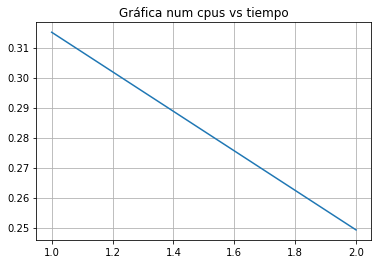

In [82]:
plt.plot(n_cpus,l)
plt.title('Gráfica num cpus vs tiempo')
plt.grid()
plt.show()

**Referencias**

1. M. Gorelick, I. Ozsvald, High Performance Python, O'Reilly Media, 2014.
